In [1]:
%pip install numpy matplotlib seaborn scikit-learn torch pandas jupyter

Note: you may need to restart the kernel to use updated packages.


## Импорты

In [2]:
# Блок 1: Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings

warnings.filterwarnings('ignore')

## Генерация датасета

In [3]:
X, y = make_classification(
    n_samples=2000,      # 2000 образцов
    n_features=20,       # 20 признаков
    n_informative=15,    # 15 информативных признаков
    n_redundant=5,       # 5 избыточных признаков
    n_clusters_per_class=2,  # 2 кластера на класс
    flip_y=0.05,         # 5% шума
    random_state=42
)

## Визуализация

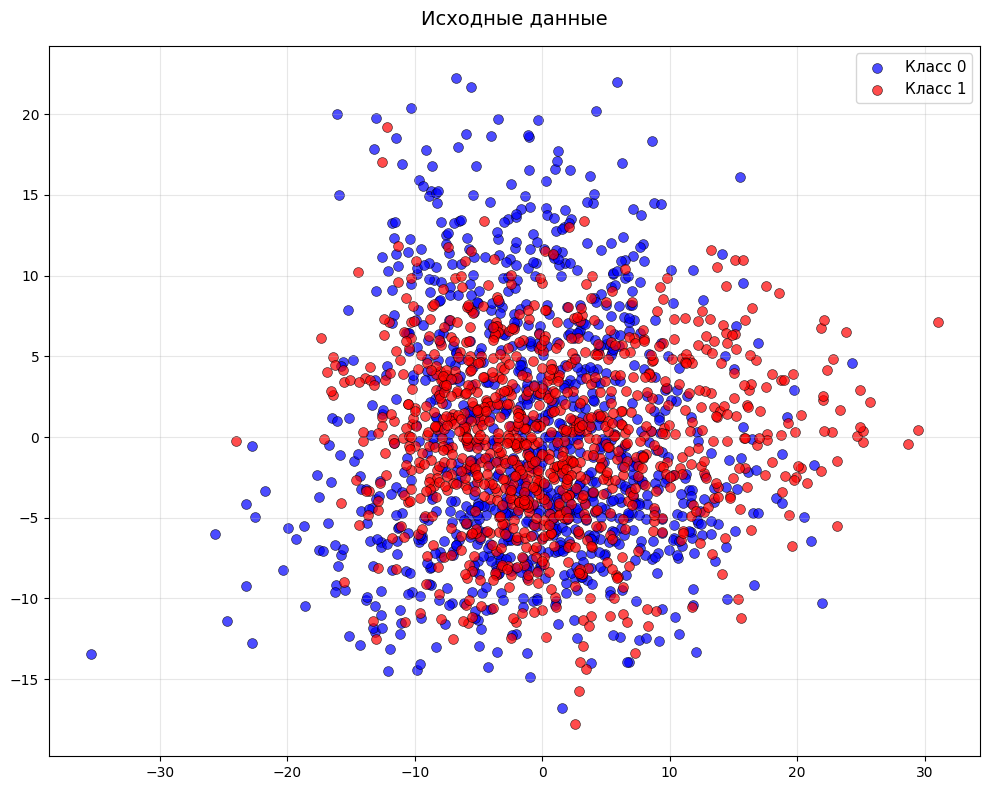

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

class_0_points = X_pca[y == 0]
class_1_points = X_pca[y == 1]

plt.figure(figsize=(10, 8))

plt.scatter(class_0_points[:, 0], class_0_points[:, 1], 
           color='blue', alpha=0.7, s=50, edgecolors='k', linewidth=0.5,
           label=f'Класс 0')

plt.scatter(class_1_points[:, 0], class_1_points[:, 1], 
           color='red', alpha=0.7, s=50, edgecolors='k', linewidth=0.5,
           label=f'Класс 1')

plt.title('Исходные данные', fontsize=14, pad=15)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Разделение данных

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Построение нейронной сети

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, use_dropout=False, dropout_rate=0.5):
        super(NeuralNetwork, self).__init__()
        
        self.fc1 = nn.Linear(20, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(p=dropout_rate)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        if self.use_dropout:
            x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        if self.use_dropout:
            x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.sigmoid(x)
        
        return x

model_no_dropout = NeuralNetwork(use_dropout=False)

## Функция для обучения модели

In [12]:
def train_and_evaluate(model, optimizer_class, optimizer_params, 
                       num_epochs=300, model_name="Модель"):
    
    print(f"ОБУЧЕНИЕ: {model_name}\n")
    
    model_copy = NeuralNetwork(use_dropout=model.use_dropout)
    model_copy.load_state_dict(model.state_dict())
    
    optimizer = optimizer_class(model_copy.parameters(), **optimizer_params)
    
    criterion = nn.BCELoss()
    
    train_losses = []
    
    model_copy.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        batch_count = 0
        
        for batch_X, batch_y in train_loader:
            outputs = model_copy(batch_X)
            loss = criterion(outputs, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            batch_count += 1
        
        avg_loss = epoch_loss / batch_count
        train_losses.append(avg_loss)
        
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"  Эпоха [{epoch+1:3d}/{num_epochs}], "
                  f"Потеря: {avg_loss:.4f}")
    
    model_copy.eval()
    with torch.no_grad():
        test_outputs = model_copy(X_test_tensor)
        test_preds = (test_outputs > 0.5).float()
        test_accuracy = accuracy_score(y_test, test_preds.numpy())
    
    print(f"\n  Финальная точность на тесте: {test_accuracy*100:.2f}%\n")
    
    # Возвращаем результаты
    return {
        'model_name': model_name,
        'optimizer': optimizer_class.__name__,
        'optimizer_params': optimizer_params,
        'train_losses': train_losses,
        'test_accuracy': test_accuracy,
        'final_model': model_copy
    }

## Исследование влияния классификаторов

In [24]:
optimizers_config = [
    {
        'name': 'SGD',
        'class': optim.SGD,
        'params': {
            'lr': 0.01,
            'momentum': 0.9,
            'weight_decay': 0.001
        },
    },
    {
        'name': 'Adam',
        'class': optim.Adam,
        'params': {
            'lr': 0.001,
            'betas': (0.9, 0.999),
            'weight_decay': 0.001
        },
    },
    {
        'name': 'RMSprop',
        'class': optim.RMSprop,
        'params': {
            'lr': 0.001,
            'alpha': 0.99,
            'weight_decay': 0.001
        },
    }
]

results_no_dropout = []

for opt_config in optimizers_config:
    
    results = train_and_evaluate(
        model=model_no_dropout,
        optimizer_class=opt_config['class'],
        optimizer_params=opt_config['params'],
        num_epochs=300,
        model_name=opt_config['name'].split()[0]
    )
    
    results['full_name'] = opt_config['name']
    results_no_dropout.append(results)

ОБУЧЕНИЕ: SGD

  Эпоха [  1/300], Потеря: 0.6877
  Эпоха [100/300], Потеря: 0.0510
  Эпоха [200/300], Потеря: 0.0182
  Эпоха [300/300], Потеря: 0.0222

  Финальная точность на тесте: 92.25%

ОБУЧЕНИЕ: Adam

  Эпоха [  1/300], Потеря: 0.6717
  Эпоха [100/300], Потеря: 0.0642
  Эпоха [200/300], Потеря: 0.0239
  Эпоха [300/300], Потеря: 0.0170

  Финальная точность на тесте: 91.25%

ОБУЧЕНИЕ: RMSprop

  Эпоха [  1/300], Потеря: 0.5415
  Эпоха [100/300], Потеря: 0.0743
  Эпоха [200/300], Потеря: 0.0284
  Эпоха [300/300], Потеря: 0.0196

  Финальная точность на тесте: 92.00%



## Визуализация результатов

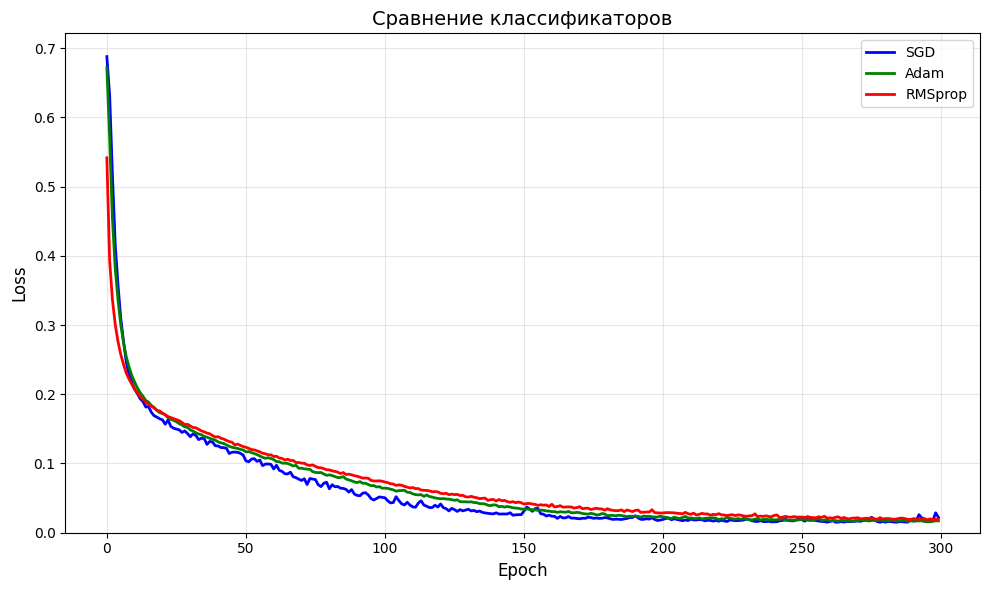

In [ ]:
plt.figure(figsize=(10, 6))

colors = {'SGD': 'blue', 'Adam': 'green', 'RMSprop': 'red'}
for result in results_no_dropout:
    color = colors.get(result['model_name'].split()[0], 'black')
    plt.plot(result['train_losses'], 
             label=f"{result['model_name']}",
             color=color, linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Сравнение классификаторов', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

## Добавление Dropout

In [31]:
dropout_rate = 0.3
model_with_dropout = NeuralNetwork(use_dropout=True, dropout_rate=dropout_rate)

optimizers_config_dropout = [
    {
        'name': 'SGD (с Dropout)',
        'class': optim.SGD,
        'params': {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.001},
        'description': 'SGD с Dropout регуляризацией'
    },
    {
        'name': 'Adam (с Dropout)',
        'class': optim.Adam,
        'params': {'lr': 0.001, 'weight_decay': 0.001},
        'description': 'Adam с Dropout регуляризацией'
    },
    {
        'name': 'RMSprop (с Dropout)',
        'class': optim.RMSprop,
        'params': {'lr': 0.001, 'alpha': 0.99, 'weight_decay': 0.001},
        'description': 'RMSprop с Dropout регуляризацией'
    }
]

results_with_dropout = []

for opt_config in optimizers_config_dropout:
    
    results = train_and_evaluate(
        model=model_with_dropout,
        optimizer_class=opt_config['class'],
        optimizer_params=opt_config['params'],
        num_epochs=300,
        model_name=opt_config['name'].split('(')[0].strip()  # Берем только имя оптимизатора
    )
    
    results['full_name'] = opt_config['name']
    results['dropout_rate'] = dropout_rate
    results_with_dropout.append(results)

ОБУЧЕНИЕ: SGD

  Эпоха [  1/300], Потеря: 0.6858
  Эпоха [100/300], Потеря: 0.2630
  Эпоха [200/300], Потеря: 0.2579
  Эпоха [300/300], Потеря: 0.2562

  Финальная точность на тесте: 93.50%

ОБУЧЕНИЕ: Adam

  Эпоха [  1/300], Потеря: 0.6826
  Эпоха [100/300], Потеря: 0.2488
  Эпоха [200/300], Потеря: 0.2708
  Эпоха [300/300], Потеря: 0.2201

  Финальная точность на тесте: 94.50%

ОБУЧЕНИЕ: RMSprop

  Эпоха [  1/300], Потеря: 0.6505
  Эпоха [100/300], Потеря: 0.2582
  Эпоха [200/300], Потеря: 0.2342
  Эпоха [300/300], Потеря: 0.2545

  Финальная точность на тесте: 94.25%



## Визуализация сравнения

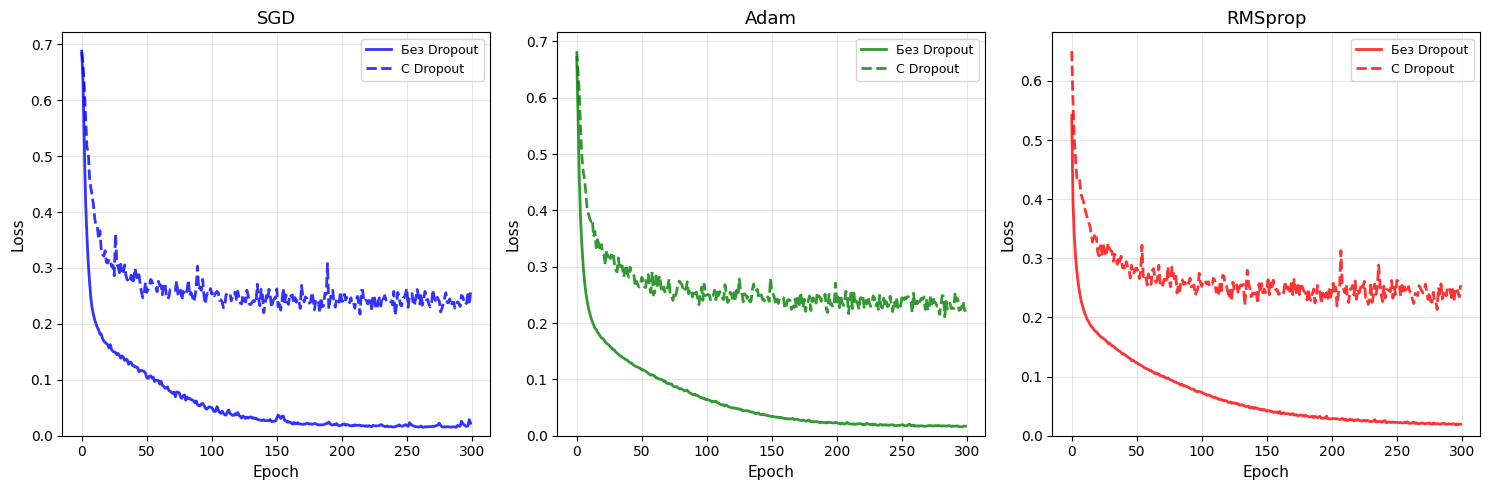

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = {'SGD': 'blue', 'Adam': 'green', 'RMSprop': 'red'}

for idx, opt_name in enumerate(['SGD', 'Adam', 'RMSprop']):
    result_no = next(r for r in results_no_dropout if r['model_name'] == opt_name)
    result_with = next(r for r in results_with_dropout if r['model_name'] == opt_name)
    
    color = colors[opt_name]
    
    axes[idx].plot(result_no['train_losses'], 
                  label=f'Без Dropout',
                  color=color, linewidth=2, alpha=0.8)
    axes[idx].plot(result_with['train_losses'], 
                  label=f'С Dropout',
                  color=color, linewidth=2, linestyle='--', alpha=0.8)
    
    # Настройки графика
    axes[idx].set_xlabel('Epoch', fontsize=11)
    axes[idx].set_ylabel('Loss', fontsize=11)
    axes[idx].set_title(f'{opt_name}', fontsize=13)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend(fontsize=9)
    axes[idx].set_ylim(bottom=0)

plt.tight_layout()
plt.show()

### **Небольшой вывод:**
    Как видим на графиках и в описании при обучения, Dropout имеет эффект сильной регуляризации, шума стало гораздо меньше и точность возросла